In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import optuna
import random
from datetime import datetime
import pytz

# importo los .py
import sys
sys.path.append("auxiliares")
import config
import metricas
import lightgbm_aux
import extras

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
arch_entrada = "datasets/emp3_sellout_producto_fe.csv"
carpeta_exp_prefijo = "exp/intermedia_1/"

In [4]:
def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = metricas.error_rate(labels,preds)
    return 'ER', ret_val, False

In [5]:
def objective(trial):
    print("****************", config.OBJECTIVE_PARAM, "****************")
    
    lgb_params = {
        'objective': config.OBJECTIVE_PARAM,
        'first_metric_only': True,
        'boost_from_average': True,
        'max_depth':-1,
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.0,config.L1_UPPER_PARAM),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0.0,config.L2_UPPER_PARAM),
        'min_gain_to_split':0.0,
        'force_row_wise':True,
        'feature_pre_filter':False,
        'metric': "None",
        'max_bin': config.MAX_BIN_PARAM,
        'learning_rate': trial.suggest_uniform('learning_rate', config.LEARNING_RATE_LOWER_PARAM,config.LEARNING_RATE_UPPER_PARAM ),
        'num_leaves' : trial.suggest_int('num_leaves', config.NUM_LEAVES_LOWER_PARAM, config.NUM_LEAVES_UPPER_PARAM),
        'feature_fraction': trial.suggest_uniform('feature_fraction', config.FEATURE_FRACTION_LOWER_PARAM, config.FEATURE_FRACTION_UPPER_PARAM),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', config.MIN_DATA_IN_LEAF_LOWER_PARAM, config.MIN_DATA_IN_LEAF_UPPER_PARAM),
        #'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        #'bagging_fraction': trial.suggest_categorical('bagging_fraction',[0.7,0.75,0.8,0.85,0.9,0.95]),
        #'extra_trees':trial.suggest_categorical('extra_trees',[True,False]),
        'verbose':-100,
        'num_threads':-1
    }
    
    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro
    
    lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols_entren)
    lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols_entren)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = metricas.error_rate(y_validate,y_pred_validate)
    
    GLOBAL_PARAMS_ITER.append(lgb_params)
    GLOBAL_BEST_IT_ITER.append(model.best_iteration)
    GLOBAL_ER_VALIDATE_ITER.append(er_validate)
    GLOBAL_MODEL_ITER.append(model)
    
    return er_validate

In [6]:
##############################################

In [7]:
df_sellout = pd.read_csv(arch_entrada)
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35888 entries, 0 to 35887
Columns: 446 entries, product_id to cat3_tn_bollinger_band_lower_15
dtypes: bool(1), float64(437), int64(5), object(3)
memory usage: 121.9+ MB


In [8]:
df_prods_prediccion_entren=pd.read_csv(config.ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO)
df_prods_prediccion_entren.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   product_id  868 non-null    int64
dtypes: int64(1)
memory usage: 6.9 KB


In [9]:
### Categoricas
df_sellout = extras.convertir_categoricas_prod(df_sellout)

In [10]:
### Split de datasets
df_train = df_sellout[(df_sellout.periodo <= config.TRAIN_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
df_validate = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion_entren.product_id)) & (df_sellout.periodo == config.VALIDATE_PERIODO_PARAM)]

print("Periodos entrenar:",df_train.periodo.unique())
print("Periodos validar:",df_validate.periodo.unique())

df_validate = df_validate.sort_values(by="product_id",ascending=True)
print("product_id a validar:", len(df_validate))

Periodos entrenar: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810]
Periodos validar: [201812]
product_id a validar: 868


In [11]:
### Armado variables entrenamiento
cols_remover_entren = ["tn_mas_2","periodo"]

# Train - Validate
X_train = df_train.drop(columns=cols_remover_entren, axis=1)
X_validate = df_validate.drop(columns=cols_remover_entren, axis=1)

y_train = df_train.tn_mas_2
y_validate = df_validate.tn_mas_2

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nX_validate:", X_validate.shape)
print("y_validate:", y_validate.shape)

cols_entren = X_train.columns.tolist()

X_train: (20016, 444)
y_train: (20016,)

X_validate: (868, 444)
y_validate: (868,)


In [12]:
### Optimizacion Bayesiana
GLOBAL_PARAMS_ITER = []
GLOBAL_BEST_IT_ITER = []
GLOBAL_ER_VALIDATE_ITER = []
GLOBAL_MODEL_ITER = []

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=config.CANT_ITERACIONES_OPT_BAY_PARAM)
print('# Experimentos:', len(study.trials))
print('Mejor experimento:', study.best_trial.params)

[I 2023-12-10 20:00:26,226] A new study created in memory with name: no-name-24451ab5-8ea1-433e-bec0-e6539e0147d5


**************** regression_l1 ****************
Training until validation scores don't improve for 68 rounds
[100]	valid_0's ER: 34.08
[200]	valid_0's ER: 32.63
[300]	valid_0's ER: 31.43
[400]	valid_0's ER: 30.37
[500]	valid_0's ER: 30.02
[600]	valid_0's ER: 29.69
[700]	valid_0's ER: 29.47


[I 2023-12-10 20:00:39,549] Trial 0 finished with value: 29.43 and parameters: {'lambda_l1': 35.90950950418237, 'lambda_l2': 61.256450579817766, 'learning_rate': 0.26862368894902877, 'num_leaves': 395, 'feature_fraction': 0.9452602646108821, 'min_data_in_leaf': 1793}. Best is trial 0 with value: 29.43.


[800]	valid_0's ER: 29.47
Early stopping, best iteration is:
[737]	valid_0's ER: 29.43
Evaluated only: ER
**************** regression_l1 ****************
Training until validation scores don't improve for 101 rounds
[100]	valid_0's ER: 40.57
[200]	valid_0's ER: 39.39
[300]	valid_0's ER: 38.44
[400]	valid_0's ER: 37.59
[500]	valid_0's ER: 36.97
[600]	valid_0's ER: 36.36
[700]	valid_0's ER: 35.84
[800]	valid_0's ER: 35.46
[900]	valid_0's ER: 35.15
[1000]	valid_0's ER: 34.9
[1100]	valid_0's ER: 34.68
[1200]	valid_0's ER: 34.45
[1300]	valid_0's ER: 34.26
[1400]	valid_0's ER: 34.03
[1500]	valid_0's ER: 33.76
[1600]	valid_0's ER: 33.52
[1700]	valid_0's ER: 33.32
[1800]	valid_0's ER: 33.14
[1900]	valid_0's ER: 32.96
[2000]	valid_0's ER: 32.82
[2100]	valid_0's ER: 32.71
[2200]	valid_0's ER: 32.58
[2300]	valid_0's ER: 32.44
[2400]	valid_0's ER: 32.34
[2500]	valid_0's ER: 32.19
[2600]	valid_0's ER: 32.08
[2700]	valid_0's ER: 31.96
[2800]	valid_0's ER: 31.85
[2900]	valid_0's ER: 31.77
[3000]	vali

[I 2023-12-10 20:01:16,666] Trial 1 finished with value: 30.91 and parameters: {'lambda_l1': 169.7111408821993, 'lambda_l2': 797.3101354971344, 'learning_rate': 0.09648829575203265, 'num_leaves': 89, 'feature_fraction': 0.5958755947177559, 'min_data_in_leaf': 2586}. Best is trial 0 with value: 29.43.


Early stopping, best iteration is:
[3758]	valid_0's ER: 30.91
Evaluated only: ER
**************** regression_l1 ****************
Training until validation scores don't improve for 67 rounds
[100]	valid_0's ER: 51.23
[200]	valid_0's ER: 47.43


[I 2023-12-10 20:01:19,230] Trial 2 finished with value: 46.46 and parameters: {'lambda_l1': 597.9018802908421, 'lambda_l2': 185.68627592416553, 'learning_rate': 0.28796728583590603, 'num_leaves': 193, 'feature_fraction': 0.5945576596399658, 'min_data_in_leaf': 5813}. Best is trial 0 with value: 29.43.


[300]	valid_0's ER: 46.46
Early stopping, best iteration is:
[240]	valid_0's ER: 46.46
Evaluated only: ER
**************** regression_l1 ****************
Training until validation scores don't improve for 72 rounds
[100]	valid_0's ER: 60.06
[200]	valid_0's ER: 57.96
[300]	valid_0's ER: 55.68
[400]	valid_0's ER: 54.14
[500]	valid_0's ER: 52.78
[600]	valid_0's ER: 51.69
[700]	valid_0's ER: 50.82


[I 2023-12-10 20:01:24,882] Trial 3 finished with value: 50.82 and parameters: {'lambda_l1': 810.8872526936703, 'lambda_l2': 319.2515223658808, 'learning_rate': 0.22297186828099455, 'num_leaves': 885, 'feature_fraction': 0.6490560118775985, 'min_data_in_leaf': 6796}. Best is trial 0 with value: 29.43.


Early stopping, best iteration is:
[683]	valid_0's ER: 50.82
Evaluated only: ER
**************** regression_l1 ****************
Training until validation scores don't improve for 75 rounds
[100]	valid_0's ER: 37.51
[200]	valid_0's ER: 35.39
[300]	valid_0's ER: 34.06
[400]	valid_0's ER: 32.91
[500]	valid_0's ER: 32.03
[600]	valid_0's ER: 31.8
[700]	valid_0's ER: 31.49
[800]	valid_0's ER: 31.37
[900]	valid_0's ER: 30.92


[I 2023-12-10 20:01:33,514] Trial 4 finished with value: 30.91 and parameters: {'lambda_l1': 209.9629463577829, 'lambda_l2': 283.8246683652876, 'learning_rate': 0.19284715587732512, 'num_leaves': 571, 'feature_fraction': 0.5775897932649543, 'min_data_in_leaf': 2089}. Best is trial 0 with value: 29.43.


Early stopping, best iteration is:
[886]	valid_0's ER: 30.91
Evaluated only: ER
# Experimentos: 5
Mejor experimento: {'lambda_l1': 35.90950950418237, 'lambda_l2': 61.256450579817766, 'learning_rate': 0.26862368894902877, 'num_leaves': 395, 'feature_fraction': 0.9452602646108821, 'min_data_in_leaf': 1793}


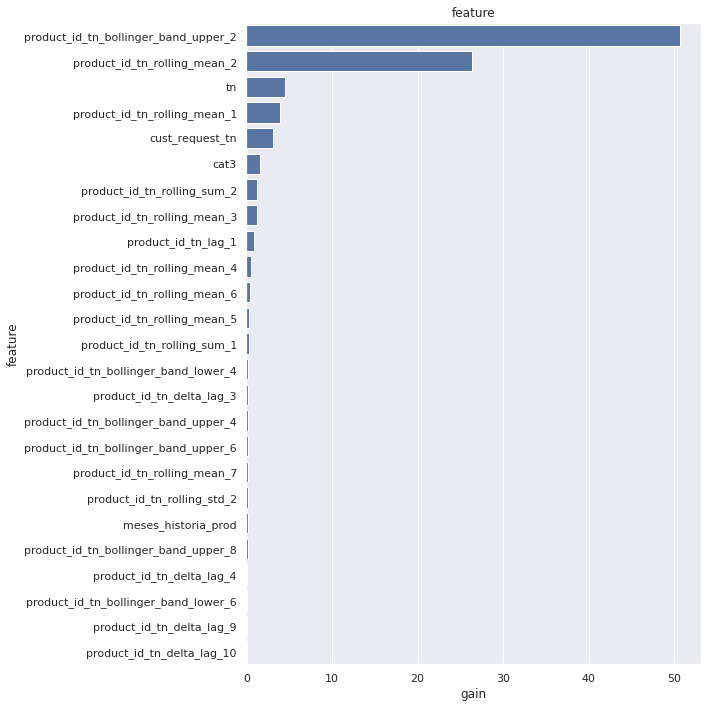

In [13]:
# Feature Importance
best_model_index = study.best_trial.number
best_model = GLOBAL_MODEL_ITER[best_model_index]
feature_importance = lightgbm_aux.plot_lgb_importances(best_model, num=30, plot=True)

In [14]:
#Si se usa holdout, se generan variables para luego evaluar modelos
if(config.USAR_HOLDOUT_PARAM):
    # Dataframes
    df_train_all = df_sellout[(df_sellout.periodo <= config.TRAIN_ALL_PERIODO_LIMITE_PARAM) & (df_sellout.periodo >= config.PERIODO_INICIO_PARAM)]
    df_holdout = df_sellout[(df_sellout.product_id.isin(df_prods_prediccion_entren.product_id)) & (df_sellout.periodo == config.HOLDOUT_PERIODO_PARAM)]
    
    df_holdout = df_holdout.sort_values(by="product_id",ascending=True)
    print("product_id a testear:", len(df_holdout))

    print("Periodos entrenar ALL:",df_train_all.periodo.unique())
    print("Periodos holdout:",df_holdout.periodo.unique())

    # Variables entrenamiento
    X_train_all = df_train_all.drop(columns=cols_remover_entren, axis=1)
    X_holdout = df_holdout.drop(columns=cols_remover_entren, axis=1)
    
    y_train_all = df_train_all.tn_mas_2
    y_holdout = df_holdout.tn_mas_2
    print("\nX_train_all:", X_train_all.shape)
    print("y_train_all:", y_train_all.shape)
    
    print("\nX_holdout:", X_holdout.shape)
    print("y_holdout:", y_holdout.shape)

    lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols_entren)

product_id a testear: 868
Periodos entrenar ALL: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812]
Periodos holdout: [201902]

X_train_all: (22118, 444)
y_train_all: (22118,)

X_holdout: (868, 444)
y_holdout: (868,)


In [15]:
current_datetime = datetime.now().astimezone(pytz.timezone('America/Argentina/Buenos_Aires'))
exp_numero = current_datetime.strftime("%Y%m%d %H%M%S").replace(" ", "_")
exp_numero

'20231210_170134'

In [16]:
# Guardo resultados
carpeta_exp = carpeta_exp_prefijo + exp_numero + "/"
if not os.path.exists(carpeta_exp):
    os.makedirs(carpeta_exp)
    
# Feature Importance
feature_importance.to_csv(carpeta_exp + "feature_importance.csv",index=False)

# Parametros
parametros_nombres = ["PERIODO_INICIO_PARAM","TRAIN_PERIODO_LIMITE_PARAM","VALIDATE_PERIODO_PARAM","USAR_HOLDOUT_PARAM",
                      "TRAIN_ALL_PERIODO_LIMITE_PARAM","HOLDOUT_PERIODO_PARAM",
                      "MODELO_FINAL_PERIODO_LIMITE_PARAM","FUTURE_PERIODO_PARAM",
                      "ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO","ARCH_PRODUCTOS_PREDICCION_FUTURE",
                      "NUM_LAGS_PARAM","FAMILIA_FEATURES_TEMP_PARAM",
                      "CANT_ITERACIONES_OPT_BAY_PARAM","CANT_SEMILLAS"]

parametros_valores = [config.PERIODO_INICIO_PARAM,config.TRAIN_PERIODO_LIMITE_PARAM,config.VALIDATE_PERIODO_PARAM,
                      config.USAR_HOLDOUT_PARAM,config.TRAIN_ALL_PERIODO_LIMITE_PARAM,config.HOLDOUT_PERIODO_PARAM,
                      config.MODELO_FINAL_PERIODO_LIMITE_PARAM,config.FUTURE_PERIODO_PARAM,
                      config.ARCH_PRODUCTOS_PREDICCION_ENTRENAMIENTO,config.ARCH_PRODUCTOS_PREDICCION_FUTURE,
                      config.NUM_LAGS_PARAM,config.FAMILIA_FEATURES_TEMP_PARAM,
                      config.CANT_ITERACIONES_OPT_BAY_PARAM, config.CANT_SEMILLAS]

parametros = pd.DataFrame(data={"nombre":parametros_nombres,"valor":parametros_valores})
parametros.to_csv(carpeta_exp + "parametros.csv",index=False)

# Optimizacion Bayesiana
df_opt_bay = pd.DataFrame(data={"index":range(0,len(GLOBAL_PARAMS_ITER)),"lgb_params":GLOBAL_PARAMS_ITER,"best_iteration":GLOBAL_BEST_IT_ITER,
                                "error_rate_validate":GLOBAL_ER_VALIDATE_ITER})

# Ordeno de menor a mayor
df_opt_bay = df_opt_bay.sort_values(by="error_rate_validate",ascending=True)

# Holdout
if(config.USAR_HOLDOUT_PARAM):
    er_holdout_iter = [None] * len(df_opt_bay)
    er_holdout_semillerio_iter = [None] * len(df_opt_bay)
    
    for i in range(config.OFFSET_EVAL_HOLDOUT,config.CANT_EVAL_HOLDOUT):
        print("Iteración:",i)

        #Modelo Train All (Sin Semillerio)
        model_train_all = lgb.train(df_opt_bay.iloc[i].lgb_params, lgbtrain_all, num_boost_round=df_opt_bay.iloc[i].best_iteration)
        y_pred_holdout = model_train_all.predict(X_holdout)
        er_holdout = metricas.error_rate(y_holdout,y_pred_holdout)
        er_holdout_iter[i]=er_holdout
        
        #Semillerio
        y_pred_holdout_semillerio = lightgbm_aux.semillerio(lgbtrain_all, df_opt_bay.iloc[i].lgb_params, df_opt_bay.iloc[i].best_iteration, X_holdout,config.CANT_SEMILLAS)
        er_holdout_semillerio_iter[i]= metricas.error_rate(y_holdout,y_pred_holdout_semillerio)
        
    df_opt_bay["error_rate_holdout"]=er_holdout_iter    
    df_opt_bay["error_rate_holdout_semillerio"]=er_holdout_semillerio_iter    

df_opt_bay.to_excel(carpeta_exp +  "opt_bay.xlsx",index=False)

Iteración: 0
Iteración: 1
Iteración: 2
